In [1]:
import pandas as pd
import datetime
from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests  
from selenium import webdriver
import csv  
import time
import datetime
import os
headers = {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:66.0) Gecko/20100101 Firefox/66.0", "Accept-Encoding":"gzip, deflate", "Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8", "DNT":"1","Connection":"close", "Upgrade-Insecure-Requests":"1"}

cur_time=datetime.datetime.now().strftime(" %Y %B %d_ %I_%M%p_  ").replace(' ','')


url_list=[]
#url_list.append("https://www.jiomart.com/c/groceries/staples/13")
url_list.append("https://www.jiomart.com/c/groceries/beverages/33")
url_list.append("https://www.jiomart.com/c/groceries/snacks-branded-foods/10")
url_list.append("https://www.jiomart.com/c/groceries/2")

for url in url_list:    
    driver = webdriver.Chrome()
    driver.get(url)
    driver.implicitly_wait(50)
    
    scroll = 1
    last_height = driver.execute_script("return document.body.scrollHeight")
    
    NameList=[]
    DiscountList=[]
    MRPL=[]
    tagL=[]
    PerUnitL=[]
    BrandList=[]
    brand_set = set()
    sku_set = set()
    num_scrolls = 10

    driver.implicitly_wait(5)
    pageHeight = driver.execute_script("return document.body.scrollHeight")

    scroll = 1
    y = 500
    no_item=0
    while True:     
        #new_height = driver.execute_script("return document.body.scrollHeight")
        prevpageheight = pageHeight
        pageHeight = driver.execute_script("return document.body.scrollHeight")
        totalScrolledHeight = driver.execute_script("return window.pageYOffset + window.innerHeight")
        print("pageHeight: ", pageHeight)
        print('totalScrolledHeight: ',totalScrolledHeight)
        if(prevpageheight > pageHeight):
            scroll = scroll-2
            y=200

        if((pageHeight - totalScrolledHeight)<200):
            print("Scrolling UP")
            y=y-175
            driver.execute_script("window.scrollTo(0, "+str(y)+")")
            continue
        else:
            y=y+200
        
        driver.execute_script("window.scrollTo(0, "+str(y)+")")
        
        time.sleep(0.9)
        scroll = scroll + 1
        print('scroll:',scroll)
    
        if scroll == 90 or no_item==45:
            print()
            break
        
    
            
        soup = BeautifulSoup(driver.page_source, "html.parser")
        filename = url.replace("/","_").replace(":","_")

        #tag = soup.find_all(class_='gtmEvents')
        # Find all elements with class 'x'
        MasterskuList = soup.find_all(class_='ais-InfiniteHits-item jm-col-4 jm-mt-base')
        for it_sku in MasterskuList:
            elements_with_class_x = it_sku.find_all(class_='gtmEvents')
            
            # Specify the attribute you want to find
            target_attribute = 'data-manu'
            
            # Iterate through the elements and find the specific attribute
            for element in elements_with_class_x:
                
                skulist =it_sku.find_all(class_="plp-card-details-container") 
                new_elem = 0
                for sku in skulist:
                    sp = sku.find_all(class_='plp-card-details-name line-clamp jm-body-xs jm-fc-primary-grey-80')
                    for item in sp:
                        item_name = item.get_text()
                #        print("Name exists"+ item.get_text())
                    if item_name in sku_set:
                        continue
                    else:
                        new_elem = new_elem+1
                        sku_set.add(item.get_text())
                    NameList.append(item.get_text())
                    if target_attribute in element.attrs:
                        brand_set.add(element[target_attribute])
                        value = element[target_attribute]
                        BrandList.append(value)
                        print(f"Element: {target_attribute}: {value}")
                    else:
                        print(f"Element: {element}, {target_attribute}: Not found")

                    
                    discountlist= sku.find_all(class_='jm-heading-xxs jm-mb-xxs') 
                    if not discountlist:
                        DiscountList.append('0')
                    else:
                        for discountPrice in discountlist:
                            #print("Discount Price= "+discountPrice.get_text())
                            discPr=discountPrice.get_text().replace("₹","")
                            DiscountList.append(discPr.replace("₹",""))
                
                    
                    MRPlist= sku.find_all(class_='jm-body-xxs jm-fc-primary-grey-60 line-through jm-mb-xxs')
                    
                    if not MRPlist:
                         MRPL.append(discPr)
                    else:
                        for mrp in MRPlist:
                            #print('MRP Price='+mrp.get_text())
                            MRPL.append(mrp.get_text().replace("₹",""))
                
                    TagList=sku.find_all(class_="jm-badge jm-badge-popular-curve jm-badge-popular-curve-small")
                    if not TagList:
                         tagL.append("None")
                    else:
                        for tag in TagList:
                            #print('Tag ='+tag.get_text())
                            tagL.append(tag.get_text())
                
                    UnitList=sku.find_all(class_="jm-body-xxs jm-fc-primary-grey-60 jm-ml-xxs uom")
                    if not UnitList:
                         PerUnitL.append("None")
                    else:
                        for perunit in UnitList:
                            #print('Tag ='+perunit.get_text())
                            PerUnitL.append(perunit.get_text().replace("₹",""))
                    print("list NameList",len(NameList), " MRPList",len(MRPL), " DiscountList:",len(DiscountList),' Tag:',len(tagL), ' PerUnitL:',len(PerUnitL))
        if new_elem == 0:
            print('scroll: -->',scroll)
            scroll = scroll -1
            no_item =no_item+1
        else :
            no_item=0
        #print('\n\n')
    driver.close()
    print("list NameList",len(NameList), "\n\nMRPList",len(MRPL), "\n\nDiscountList:",len(DiscountList),'\n\nTag:',len(tagL), '\n\nPerUnitL:',len(PerUnitL), '\n\nBrandList:',len(BrandList))
    dict1={'Product name': NameList, 'MRP': MRPL, 'Discount': DiscountList, 'Tag':tagL, 'PerUnitPrice':PerUnitL, 'Brand':BrandList}    
    df = pd.DataFrame(dict1)
    if not os.path.isdir(cur_time):
        os.mkdir(cur_time)
    df.to_csv(cur_time+'\\'+filename+".csv") 
 


pageHeight:  3285
totalScrolledHeight:  515
scroll: 2
Element: data-manu: PRIYA
list NameList 1  MRPList 1  DiscountList: 1  Tag: 1  PerUnitL: 1
Element: data-manu: YOGABAR
list NameList 2  MRPList 2  DiscountList: 2  Tag: 2  PerUnitL: 2
Element: data-manu: SUPER SARVOTTAM
list NameList 3  MRPList 3  DiscountList: 3  Tag: 3  PerUnitL: 3
Element: data-manu: FORTUNE
list NameList 4  MRPList 4  DiscountList: 4  Tag: 4  PerUnitL: 4
Element: data-manu: TATA
list NameList 5  MRPList 5  DiscountList: 5  Tag: 5  PerUnitL: 5
Element: data-manu: BHOJ MASALE
list NameList 6  MRPList 6  DiscountList: 6  Tag: 6  PerUnitL: 6
Element: data-manu: PRIVATE LABEL
list NameList 7  MRPList 7  DiscountList: 7  Tag: 7  PerUnitL: 7
Element: data-manu: FORTUNE
list NameList 8  MRPList 8  DiscountList: 8  Tag: 8  PerUnitL: 8
Element: data-manu: GOOD LIFE
list NameList 9  MRPList 9  DiscountList: 9  Tag: 9  PerUnitL: 9
Element: data-manu: GOOD LIFE
list NameList 10  MRPList 10  DiscountList: 10  Tag: 10  PerUnit

NoSuchWindowException: Message: no such window: target window already closed
from unknown error: web view not found
  (Session info: chrome=119.0.6045.200)
Stacktrace:
	GetHandleVerifier [0x00007FF6C31382B2+55298]
	(No symbol) [0x00007FF6C30A5E02]
	(No symbol) [0x00007FF6C2F605AB]
	(No symbol) [0x00007FF6C2F40038]
	(No symbol) [0x00007FF6C2FC6BC7]
	(No symbol) [0x00007FF6C2FDA15F]
	(No symbol) [0x00007FF6C2FC1E83]
	(No symbol) [0x00007FF6C2F9670A]
	(No symbol) [0x00007FF6C2F97964]
	GetHandleVerifier [0x00007FF6C34B0AAB+3694587]
	GetHandleVerifier [0x00007FF6C350728E+4048862]
	GetHandleVerifier [0x00007FF6C34FF173+4015811]
	GetHandleVerifier [0x00007FF6C31D47D6+695590]
	(No symbol) [0x00007FF6C30B0CE8]
	(No symbol) [0x00007FF6C30ACF34]
	(No symbol) [0x00007FF6C30AD062]
	(No symbol) [0x00007FF6C309D3A3]
	BaseThreadInitThunk [0x00007FF8F61C26AD+29]
	RtlUserThreadStart [0x00007FF8F7E0AA68+40]


## Getting items from JIOMart by scrolling, Scrapping with Jio Mart with respective divs


In [144]:
import re
import csv
import pandas as pd
def replace_inside_parentheses(input_string, replacement=''):
    pattern = re.compile(r'\([^)]*\)')
    result = pattern.sub(replacement, input_string)
    return result
    
def extract_quantity_unit_and_pack(text, pattern_str):
    # Define a regular expression pattern to capture quantity, unit, and 'pack of'
    #pattern = re.compile(r'(?P<quantity>\d+(\.\d+)?)\s*(?P<unit>\w+)?(?:\s*pack of)?', re.IGNORECASE)
    #pattern = re.compile(r'(?P<quantity>\d+(\.\d+)?)\s*(?P<unit>\w+)?(?:\s*pack of)?\s*(?P<volume>\d+(\.\d+)?\s*(?:[A-Za-z]+)?)?', re.IGNORECASE)
    #pattern = re.compile(r'(?P<quantity>\d+(\.\d+)?)\s*(?P<unit>\w+)?(?:\s*pack of)?', re.IGNORECASE)
   # pattern = re.compile(r'(?P<quantity>\d+(\.\d+)?%?)\s*(?P<unit>\w+)?\s*(?:\s*pack of\s*)?', re.IGNORECASE)
   # text.replace('100%','')
    pattern = re.compile(pattern_str, re.IGNORECASE)
    # Search for the pattern in the input text
    match = pattern.search(text)

    # Check if 'pack of' is present
    pack_of_present = 'pack of' in text.lower()

    # Check if a match is found
    if match:
        # Extract quantity and unit from the match
        quantity = match.group('quantity')
        unit = match.group('unit')

        # If unit is not specified, set it to None
        unit = unit if unit else None

        return quantity, unit, pack_of_present
    else:
        return None, None, pack_of_present


reader = csv.reader(open('C:/Users/abhisriv/Documents/webscap/JoiMart/2023November23_05_10PM_/https___www.jiomart.com_c_groceries_staples_13.csv', 'r'))
writer = csv.writer(open('C:/Users/abhisriv/Documents/webscap/JoiMart/2023November23_05_10PM_/groceries_Quantity_output.csv', 'w', newline=''))
headers = next(reader)
name_index = headers.index('Product name')
brand_index = headers.index('Brand')
headers.append("Quantity")
headers.append('Unit')
headers.append('Is Pack of')
writer.writerow(headers)
for row in reader:
   # brand_set.add(row[name_index])
    text=row[name_index].replace('100%','').replace(row[brand_index],'')
    quantity, unit, pack_of_present = extract_quantity_unit_and_pack(text,r'(?P<quantity>\d+(\.\d+)?)\s*(?P<unit>\w+)?(?:\s*pack of)?\s*(?P<volume>\d+(\.\d+)?\s*(?:[A-Za-z]+)?)?')
    print(f'Item: {text}, ############ ,Quantity: {quantity}, Unit: {unit}, "Pack of" Present: {pack_of_present}')
    if unit is None:
        new_text = replace_inside_parentheses(text)
        #quantity, unit, pack_of_present = extract_quantity_unit_and_pack(new_text,r'(?P<quantity>\d+(\.\d+)?)\s*(?P<unit>\w+)?(?:\s*pack of)?\s*(?P<volume>\d+(\.\d+)?\s*(?:[A-Za-z]+)?)?')
        quantity, unit, pack_of_present = extract_quantity_unit_and_pack(new_text,r'(?P<quantity>\d+(\.\d+)?)\s*(?P<unit>\w+)(?:\s*(?:pack of|LTR|ML|GM|KG|g|kg|Litre|Grams|Gm)\s*)?')
        print(f'$$$$Again Item: {new_text}, ############ ,Quantity: {quantity}, Unit: {unit}, "Pack of" Present: {pack_of_present}')
    row.append(quantity)
    row.append(str(unit).lower())
    row.append(pack_of_present)
    writer.writerow(row)
print('Done with Quantity')

# Read the CSV file into a DataFrame
df = pd.read_csv('C:/Users/abhisriv/Documents/webscap/JoiMart/2023November23_05_10PM_/groceries_Quantity_output.csv', encoding='latin-1',thousands=',', decimal='.')

unit_conversion = {'gram': 0.001, 'kg': 1, 'liter': 1, 'ml': 0.001,'gm':0.001, 'KG':1, 'L':1, 'l':1, 'g':0.001, 'ltr':1}


# Calculate discount and discount percentage
df['Discount'] = df['MRP'].astype(float) - df['Selling Price'].astype(float)
df['Discount Percentage'] = ((df['Discount'].replace(',','').astype(float) / df['MRP'].replace(',','').astype(float)) * 100).round(2)
df['Price Per Unit(Kg/L)'] = (df['Selling Price'].replace(',','').astype(float) / (df['Quantity'].replace(',','').astype(float) * df['Unit'].map(unit_conversion))).round(2)

# Print the DataFrame with the added columns
#print(df)

# Update the CSV file with the new columns
df.to_csv('C:/Users/abhisriv/Documents/webscap/JoiMart/2023November23_05_10PM_/groceries_Quantity_clean.csv', index=False)



Item:  Priya Fortified With Vitamin A & D Refined Sunflower Oil 1 L , ############ ,Quantity: 1, Unit: L, "Pack of" Present: False
Item:  ORGANIC GREEN MOONG DAL 1KG , ############ ,Quantity: 1, Unit: KG, "Pack of" Present: False
Item:  Super Sarvottam Physically Refined Rice Bran Oil 1 L , ############ ,Quantity: 1, Unit: L, "Pack of" Present: False
Item:  Fortune Sunlite Refined Sunflower Oil 1 L , ############ ,Quantity: 1, Unit: L, "Pack of" Present: False
Item:  Fortune Refined Soyabean Oil 1 L , ############ ,Quantity: 1, Unit: L, "Pack of" Present: False
Item:  House of Veda Organic Lobia (Cowpea White) 500g , ############ ,Quantity: 500, Unit: g, "Pack of" Present: False
Item:  Tata Iodised Salt 1 kg , ############ ,Quantity: 1, Unit: kg, "Pack of" Present: False
Item:  Fortune Premium Kachi Ghani Pure Mustard Oil 1 L , ############ ,Quantity: 1, Unit: L, "Pack of" Present: False
Item:  Chakki Atta 10 kg , ############ ,Quantity: 10, Unit: kg, "Pack of" Present: False
Item:  Tu

# Applying regex and Calculating Discout/Discount Percentage/PricePerUnit For Groceries

In [53]:
import re

def extract_weight_and_unit(product_info):
    # Define a regular expression pattern to match the weight and unit information
    pattern = r"(\d+\.\d+|\d+)\s*([a-zA-Z]+)$"
    
    # Use re.search to find the match in the string
    match = re.search(pattern, product_info)

    # Check if a match is found
    if match:
        weight = match.group(1)
        unit = match.group(2)
        print(f"Weight: {weight} {unit}")
    else:
        print("No match found.")
    return weight, unit
# Example 1
product_info1 = "Cadbury 5 Star Bites Home Treats Chocolate 191.9 g"
#extract_weight_and_unit(product_info1)
#print()

# Example 2
#product_info2 = " MTR 3 Minute Breakfast Poha Mix 60 g "
#extract_weight_and_unit(product_info2)
product_info2 = "center fresh mints 3 layer peppermint sugarfree lozenges 4.5 g (15 pcs) "
#r"(\d+\.\d+|\d+)\s*([a-zA-Z]+)"
print(extract_quantity_unit_and_pack(product_info2.strip(),r"(?P<quantity>\d+(\.\d+)?)\s*(?P<unit>[a-zA-Z]+)(?:\s*\(\s*(?P<pack_quantity>\d+)\s*pcs\s*\))?$"))
print(extract_quantity_unit_and_pack(product_info2,r'(?P<quantity>\d+(\.\d+)?)\s*(?P<unit>\w+)?\s*(?P<volume>\d+(\.\d+)?\s*(?:[A-Za-z]+)?)?$'))



('4.5', 'g')
(1, None)


### Test examples for applying regex

In [59]:
import re
import csv
import pandas as pd
def replace_inside_parentheses(input_string, replacement=''):
    pattern = re.compile(r'\([^)]*\)')
    result = pattern.sub(replacement, input_string)
    return result
    
def extract_quantity_unit_and_pack(text, pattern_str):
    # Define a regular expression pattern to capture quantity, unit, and 'pack of'
    #pattern = re.compile(r'(?P<quantity>\d+(\.\d+)?)\s*(?P<unit>\w+)?(?:\s*pack of)?', re.IGNORECASE)
    #pattern = re.compile(r'(?P<quantity>\d+(\.\d+)?)\s*(?P<unit>\w+)?(?:\s*pack of)?\s*(?P<volume>\d+(\.\d+)?\s*(?:[A-Za-z]+)?)?', re.IGNORECASE)
    #pattern = re.compile(r'(?P<quantity>\d+(\.\d+)?)\s*(?P<unit>\w+)?(?:\s*pack of)?', re.IGNORECASE)
   # pattern = re.compile(r'(?P<quantity>\d+(\.\d+)?%?)\s*(?P<unit>\w+)?\s*(?:\s*pack of\s*)?', re.IGNORECASE)
   # text.replace('100%','')
    pattern = re.compile(pattern_str, re.IGNORECASE)
    # Search for the pattern in the input text
    match = pattern.search(text)

    # Check if a match is found
    if match:
        # Extract quantity and unit from the match
        quantity = match.group('quantity')
        unit = match.group('unit')

        # If unit is not specified, set it to None
        unit = unit if unit else None
        quantity = quantity if unit else None

        return quantity, unit
    else:
        return 1, None



def extract_pack_set_information(product_info):
    # Define a case-insensitive regular expression pattern to match "Pack of" and "Set of" occurrences
    pattern = re.compile("(?i)(Pack of|Set of)\s*(?P<pack>\d+(\.\d+)?)")
    
    # Use re.findall to find all matches in the string
    #matches = re.findall(pattern, product_info)
    match = pattern.search(product_info)
    # Check if matches are found
    if match:
        # Extract quantity and unit from the match
        pack = match.group('pack')
        #unit = match.group('unit')

        # If unit is not specified, set it to None
        #unit = unit if unit else None

        return pack
    return None
#def IsValidUnitQuantity()
    
unit_conversion = {'gram': 0.001, 'kg': 1, 'liter': 1, 'ml': 0.001,'gm':0.001, 'KG':1, 'L':1, 'l':1, 'g':0.001, 'ltr':1,'gms':0.001,'grams':0.001,'grms':0.001,'pc':1,'boxes':1}
reader = csv.reader(open('C:/Users/abhisriv/Documents/webscap/JoiMart/2023November23_05_10PM_/https___www.jiomart.com_c_groceries_snacks-branded-foods_10.csv', 'r', encoding='utf-8'))#encoding='latin-1'))
writer = csv.writer(open('C:/Users/abhisriv/Documents/webscap/JoiMart/2023November23_05_10PM_/snacks_brandedfood_output.csv', 'w', newline=''))
headers = next(reader)
name_index = headers.index('Product name')
brand_index = headers.index('Brand')
headers.append("Quantity")
headers.append('Unit')
headers.append('Pack of')
headers.append("Conversion")
headers.append("Platform")
writer.writerow(headers)

regexL=[]
regexL.append(r'(?P<quantity>\d+(\.\d+)?)\s*(?P<unit>\w+)?\s*(?P<volume>\d+(\.\d+)?\s*(?:[A-Za-z]+)?)?')
regexL.append(r'(?P<quantity>\d+(\.\d+)?)\s*(?P<unit>\w+)(?:\s*(?:|LTR|ML|GM|KG|g|kg|Litre|Grams|Gm|gms|grms|grams|pc)\s*)?')
regexL.append(r'(?P<quantity>\d+\.\d+|\d+)\s*(?P<unit>[a-zA-Z]+)$')
regexL.append(r'(?P<quantity>\d+(\.\d+)?)\s*(?P<unit>\w+)?\s*(?P<volume>\d+(\.\d+)?\s*(?:[A-Za-z]+)?)?$')
regexL.append(r"(?P<quantity>\d+\.\d+|\d+)\s*(?P<unit>[a-zA-Z]+)")
regexL.append(r"(?P<quantity>\d+)\s*(?P<unit>[a-zA-Z]+)(?:\s*\(\s*pack\s*of\s*\d+\s*\))?$")
regexL.append(r"(?P<quantity>\d+(\.\d+)?)\s*(?P<unit>[a-zA-Z]+)(?:\s*\(\s*(?P<pack_quantity>\d+)\s*pcs\s*\))?$")


for row in reader:
   # brand_set.add(row[name_index])
    conversion = "Success"
    text=row[name_index].replace('100%','').replace(row[brand_index],'').lower().strip()
    quantity, unit = extract_quantity_unit_and_pack(text,r'(?P<quantity>\d+(\.\d+)?)\s*(?P<unit>\w+)?\s*(?P<volume>\d+(\.\d+)?\s*(?:[A-Za-z]+)?)?')
    #print(f'Item: {text}, ############ ,Quantity: {quantity}, Unit: {unit})
    if quantity is None or unit is None or unit not in unit_conversion:
        #new_text = replace_inside_parentheses(text)
        new_text = text
        retry =1
        for regex in regexL:
            quantity, unit = extract_quantity_unit_and_pack(new_text, regex)
            if quantity is None or unit is None or unit not in unit_conversion:
               retry = retry+1
               print("retrying...",retry, " quantity", quantity, "  unit", unit, new_text)
            else:
                print("Got it For...",retry, " quantity", quantity, "  unit", unit, new_text)
                break
    if unit not in unit_conversion:
        print(text, "Unit not is Conversion #########Quantity:", quantity," Unit: ",unit)
        conversion = "Failed"
    
    
    pack_of = extract_pack_set_information(text)
    if pack_of is None:
        pack_of=1
    row.append(quantity)
    row.append(str(unit).lower())
    row.append(pack_of)
    row.append(conversion)
    row.append("JioMart")
    writer.writerow(row)
print('Done with Quantity')

# Read the CSV file into a DataFrame
df = pd.read_csv('C:/Users/abhisriv/Documents/webscap/JoiMart/2023November23_05_10PM_/snacks_brandedfood_output.csv', encoding='latin-1',thousands=',', decimal='.',on_bad_lines='skip')

# Calculate discount and discount percentage
df['Discount'] = df['MRP'].astype(float) - df['Selling Price'].astype(float)
df['Discount Percentage'] = ((df['Discount'].replace(',','').astype(float) / df['MRP'].replace(',','').astype(float)) * 100).round(2)
df['Price Per Unit(Kg/L)'] = (df['Selling Price'].replace(',','').astype(float) / (df['Quantity'].replace(',','').astype(float) * df['Unit'].map(unit_conversion))).round(2)
df = pd.read_csv('C:/Users/abhisriv/Documents/webscap/JoiMart/2023November23_05_10PM_/snacks_brandedfood_output.csv', encoding='cp1252',thousands=',', decimal='.')
# Print the DataFrame with the added columns
#print(df)

# Update the CSV file with the new columns
df.to_csv('C:/Users/abhisriv/Documents/webscap/JoiMart/2023November23_05_10PM_/snacks_brandedfood_output_clean.csv', index=False)



retrying... 2  quantity None   unit None maggi 2-minute masala noodles 70 g
Got it For... 2  quantity 70   unit g maggi 2-minute masala noodles 70 g
retrying... 2  quantity None   unit None maggi 2-minute masala instant noodles 560 g
Got it For... 2  quantity 560   unit g maggi 2-minute masala instant noodles 560 g
retrying... 2  quantity 18   unit yummy munch 18 yummy treats 160.2 g
retrying... 3  quantity 18   unit yummy munch 18 yummy treats 160.2 g
Got it For... 3  quantity 160.2   unit g munch 18 yummy treats 160.2 g
retrying... 2  quantity None   unit None maggi 2-minute masala instant noodles 420 g
Got it For... 2  quantity 420   unit g maggi 2-minute masala instant noodles 420 g
retrying... 2  quantity None   unit None luvit dairy rich roasted almond chocolates bar| delicious| rich| smooth| pack of 12- 39gm each
retrying... 3  quantity 1   unit 2 luvit dairy rich roasted almond chocolates bar| delicious| rich| smooth| pack of 12- 39gm each
retrying... 4  quantity 1   unit None 

## Calculating Discount/Discount Percentage/ Price Per Unit for Branded Food Items

In [51]:

import re
import csv
import pandas as pd
def replace_inside_parentheses(input_string, replacement=''):
    pattern = re.compile(r'\([^)]*\)')
    result = pattern.sub(replacement, input_string)
    return result
    
def extract_quantity_unit_and_pack(text, pattern_str):
    pattern = re.compile(pattern_str, re.IGNORECASE)
    # Search for the pattern in the input text
    match = pattern.search(text)

    # Check if a match is found
    if match:
        # Extract quantity and unit from the match
        quantity = match.group('quantity')
        unit = match.group('unit')

        # If unit is not specified, set it to None
        unit = unit if unit else None
        quantity = quantity if unit else None

        return quantity, unit
    else:
        return 1, None

def extract_quantity_and_unit_Bags_sachets(product_description):
    # Extract quantity and unit for Sachets or Tea Bags (quantity can be prefix or suffix)
    match = re.search(r"(\d+)\s*(?:Sachets|Tea\s*Bags|Tea\s*Bag)|\s*(?:Sachets|Tea\s*Bags|Tea\s*Bag)\s*(\d+)", product_description, re.IGNORECASE)
    if match:
        quantity = int(match.group(1) or match.group(2))
        unit_match = re.search(r"(Sachets|Tea\s*Bags|Tea\s*Bag)", product_description, re.IGNORECASE)
        unit = unit_match.group(0).lower() if unit_match else None
        return quantity, unit
    else:
        return None, None

def extract_pack_set_information(product_info):
    # Define a case-insensitive regular expression pattern to match "Pack of" and "Set of" occurrences
    pattern = re.compile("(?i)(Pack of|Set of)\s*(?P<pack>\d+(\.\d+)?)")
    
    # Use re.findall to find all matches in the string
    #matches = re.findall(pattern, product_info)
    match = pattern.search(product_info)
    # Check if matches are found
    if match:
        # Extract quantity and unit from the match
        pack = match.group('pack')
        #unit = match.group('unit')

        # If unit is not specified, set it to None
        #unit = unit if unit else None

        return pack
    return None
#def IsValidUnitQuantity()
    
unit_conversion={'gram': 0.001, 'kg': 1, 'liter': 1, 'ml': 0.001,'gm':0.001, 'KG':1, 'L':1, 'l':1, 'g':0.001, 'ltr':1,'gms':0.001,'grams':0.001,'grms':0.001,'pc':1,'boxes':1,'Bags':1,'BAGS':1,'PCS':1,'pcs':1,'Sachets':1,'sachets':1,'Bag':1,'bag':1,'tea bags':1}
reader = csv.reader(open('C:/Users/abhisriv/Documents/webscap/JoiMart/2023November23_05_10PM_/https___www.jiomart.com_c_groceries_beverages_33.csv', 'r', encoding='utf-8'))#encoding='latin-1'))
writer = csv.writer(open('C:/Users/abhisriv/Documents/webscap/JoiMart/2023November23_05_10PM_/Jio_beverages_output.csv', 'w', newline=''))
headers = next(reader)
name_index = headers.index('Product name')
brand_index = headers.index('Brand')
headers.append("Quantity")
headers.append('Unit')
headers.append('Pack of')
headers.append("Conversion")
headers.append("Platform")
writer.writerow(headers)

regexL=[]
regexL.append(r'(?P<quantity>\d+(\.\d+)?)\s*(?P<unit>\w+)?\s*(?P<volume>\d+(\.\d+)?\s*(?:[A-Za-z]+)?)?')
regexL.append(r'(?P<quantity>\d+(\.\d+)?)\s*(?P<unit>\w+)(?:\s*(?:|LTR|ML|GM|KG|g|kg|Litre|Grams|Gm|gms|grms|grams|pc|Bags|bags|PCS|PC)\s*)?')
regexL.append(r'(?P<quantity>\d+\.\d+|\d+)\s*(?P<unit>[a-zA-Z]+)$')
regexL.append(r'(?P<quantity>\d+(\.\d+)?)\s*(?P<unit>\w+)?\s*(?P<volume>\d+(\.\d+)?\s*(?:[A-Za-z]+)?)?$')
regexL.append(r"(?P<quantity>\d+\.\d+|\d+)\s*(?P<unit>[a-zA-Z]+)")
regexL.append(r"(?P<quantity>\d+)\s*(?P<unit>[a-zA-Z]+)(?:\s*\(\s*pack\s*of\s*\d+\s*\))?$")
regexL.append(r"(?P<quantity>\d+(\.\d+)?)\s*(?P<unit>[a-zA-Z]+)(?:\s*\(\s*(?P<pack_quantity>\d+)\s*pcs\s*\))?$")
regexL.append(r"(?i)(?P<quantity>\d+)\s*(?P<unit>ml|g|kg|liter(s)?)")


for row in reader:
   # brand_set.add(row[name_index])
    conversion = "Success"
    text=row[name_index].replace('100%','').replace(row[brand_index],'').lower().strip()
    quantity, unit = extract_quantity_unit_and_pack(text,r'(?P<quantity>\d+(\.\d+)?)\s*(?P<unit>\w+)?\s*(?P<volume>\d+(\.\d+)?\s*(?:[A-Za-z]+)?)?')
    #print(f'Item: {text}, ############ ,Quantity: {quantity}, Unit: {unit})
    if quantity is None or unit is None or unit not in unit_conversion:
        #new_text = replace_inside_parentheses(text)
        new_text = text
        retry =1
        for regex in regexL:
            quantity, unit = extract_quantity_unit_and_pack(new_text, regex)
            if quantity is None or unit is None or unit not in unit_conversion:
               retry = retry+1
               print("retrying...",retry, " quantity", quantity, "  unit", unit, new_text)
            else:
                print("Got it For...",retry, " quantity", quantity, "  unit", unit, new_text)
                break
    if unit not in unit_conversion:
        quantity, unit = extract_quantity_and_unit_Bags_sachets(new_text)

    if unit not in unit_conversion:
        print(text, "Unit not is Conversion #########Quantity:", quantity," Unit: ",unit)
        conversion = "Failed"
    
    
    pack_of = extract_pack_set_information(text)
    if pack_of is None:
        pack_of=1
    row.append(quantity)
    row.append(str(unit).lower())
    row.append(pack_of)
    row.append(conversion)
    row.append("JioMart")
    writer.writerow(row)
print('Done with Quantity')

# Read the CSV file into a DataFrame
df = pd.read_csv('C:/Users/abhisriv/Documents/webscap/JoiMart/2023November23_05_10PM_/Jio_beverages_output.csv', encoding='latin-1',thousands=',', decimal='.',on_bad_lines='skip')
df = df[df['conversion'] != 'Failed']
# Calculate discount and discount percentage
df['Discount'] = df['MRP'].astype(float) - df['Selling Price'].astype(float)
df['Discount Percentage'] = ((df['Discount'].replace(',','').astype(float) / df['MRP'].replace(',','').astype(float)) * 100).round(2)
df['Price Per Unit(Kg/L)'] = (df['Selling Price'].replace(',','').astype(float) / (df['Quantity'].replace(',','').astype(float) * df['Unit'].map(unit_conversion))).round(2)


# Update the CSV file with the new columns
df.to_csv('C:/Users/abhisriv/Documents/webscap/JoiMart/2023November23_05_10PM_/Jio_beverages_clean.csv', index=False)





retrying... 2  quantity 60   unit vegan biovitalia organics premium milk thistle capsules for liver health & antioxidant support - silybum marianum extract - 60 vegan capsules - dietary supplement
retrying... 3  quantity 60   unit vegan biovitalia organics premium milk thistle capsules for liver health & antioxidant support - silybum marianum extract - 60 vegan capsules - dietary supplement
retrying... 4  quantity 1   unit None biovitalia organics premium milk thistle capsules for liver health & antioxidant support - silybum marianum extract - 60 vegan capsules - dietary supplement
retrying... 5  quantity 1   unit None biovitalia organics premium milk thistle capsules for liver health & antioxidant support - silybum marianum extract - 60 vegan capsules - dietary supplement
retrying... 6  quantity 60   unit vegan biovitalia organics premium milk thistle capsules for liver health & antioxidant support - silybum marianum extract - 60 vegan capsules - dietary supplement
retrying... 7  quan

## Calculating Discount/Discount Percentage/ Price Per Unit for Beverages

In [57]:
import pandas as pd
def search_tags(search_string, tags_list):
    return any(tag in search_string for tag in tags_list)
# List of file names
file_names = [r'C:\Users\abhisriv\Documents\webscap\Clean_Dataset\BB_Beverages_clean_7dec.csv', r'C:\Users\abhisriv\Documents\webscap\Clean_Dataset\BB_foodnoil_clean_6Dec.csv', r'C:\Users\abhisriv\Documents\webscap\Clean_Dataset\BB_Snacknbranded_clean_5dec.csv']
tags_list  = ['pcs','teabags']
for file_name in file_names:
    # Load the CSV file into a DataFrame
    df = pd.read_csv(file_name)

    # Function to convert Price_per_unit to Price Per Unit(Kg/L)
    def convert_to_kg_l(row):
        
        result = search_tags(row['Quantity_upd'].lower(), tags_list)
        if result:
            return row['Price_per_unit(gm/ml/pc)']
        else:
            return row['Price_per_unit(gm/ml/pc)'] * (1000)  # Convert grams to kilograms
        
    # Apply the conversion function to create the new column
    df['Price Per Unit(Kg/L)'] = df.apply(convert_to_kg_l, axis=1)

    # Save the updated DataFrame to a new CSV file
    output_file_name = file_name.replace('.csv', '_output.csv')
    df.to_csv(output_file_name, index=False)

    print(f"Conversion completed for {file_name}. Output saved to {output_file_name}")


Conversion completed for C:\Users\abhisriv\Documents\webscap\Clean_Dataset\BB_Beverages_clean_7dec.csv. Output saved to C:\Users\abhisriv\Documents\webscap\Clean_Dataset\BB_Beverages_clean_7dec_output.csv
Conversion completed for C:\Users\abhisriv\Documents\webscap\Clean_Dataset\BB_foodnoil_clean_6Dec.csv. Output saved to C:\Users\abhisriv\Documents\webscap\Clean_Dataset\BB_foodnoil_clean_6Dec_output.csv
Conversion completed for C:\Users\abhisriv\Documents\webscap\Clean_Dataset\BB_Snacknbranded_clean_5dec.csv. Output saved to C:\Users\abhisriv\Documents\webscap\Clean_Dataset\BB_Snacknbranded_clean_5dec_output.csv


In [69]:
import pandas as pd

# List of file names
file_names = [r'C:\Users\abhisriv\Documents\webscap\Clean_Dataset\BB_Beverages_clean_7dec_output.csv', r'C:\Users\abhisriv\Documents\webscap\Clean_Dataset\BB_foodnoil_clean_6Dec_output.csv', r'C:\Users\abhisriv\Documents\webscap\Clean_Dataset\BB_Snacknbranded_clean_5dec_output.csv']

# Constant value for the new column
brand_value = 'BigBasket'

for file_name in file_names:
    # Load the CSV file into a DataFrame
    df = pd.read_csv(file_name)

    # Add a new column "Brand" with the constant value
    df['Platform'] = brand_value

    # Save the updated DataFrame to a new CSV file
    output_file_name = file_name.replace('.csv', '_CLEAN.csv')
    df.to_csv(output_file_name, index=False)

    print(f"Operation completed for {file_name}. Output saved to {output_file_name}")
# List of file names
#file_names = [r'C:\Users\abhisriv\Documents\webscap\Clean_Dataset\BB_Beverages_clean_7dec_output.csv', r'C:\Users\abhisriv\Documents\webscap\Clean_Dataset\BB_foodnoil_clean_6Dec_output.csv', r'C:\Users\abhisriv\Documents\webscap\Clean_Dataset\BB_Snacknbranded_clean_5dec_output.csv']


Operation completed for C:\Users\abhisriv\Documents\webscap\Clean_Dataset\BB_Beverages_clean_7dec_output.csv. Output saved to C:\Users\abhisriv\Documents\webscap\Clean_Dataset\BB_Beverages_clean_7dec_output_CLEAN.csv
Operation completed for C:\Users\abhisriv\Documents\webscap\Clean_Dataset\BB_foodnoil_clean_6Dec_output.csv. Output saved to C:\Users\abhisriv\Documents\webscap\Clean_Dataset\BB_foodnoil_clean_6Dec_output_CLEAN.csv
Operation completed for C:\Users\abhisriv\Documents\webscap\Clean_Dataset\BB_Snacknbranded_clean_5dec_output.csv. Output saved to C:\Users\abhisriv\Documents\webscap\Clean_Dataset\BB_Snacknbranded_clean_5dec_output_CLEAN.csv
Operation completed for C:\Users\abhisriv\Documents\webscap\Clean_Dataset\Jio_groceries_Quantity_clean.csv. Output saved to C:\Users\abhisriv\Documents\webscap\Clean_Dataset\BB_Snacknbranded_clean_5dec_output_CLEAN.csv
Operation completed for C:\Users\abhisriv\Documents\webscap\Clean_Dataset\Jio_snacks_brandedfood_output_clean.csv. Output sa

In [72]:
jio_file_names = [r'C:\Users\abhisriv\Documents\webscap\Clean_Dataset\Jio_groceries_Quantity_clean.csv', r'C:\Users\abhisriv\Documents\webscap\Clean_Dataset\Jio_snacks_brandedfood_output_clean.csv', r'C:\Users\abhisriv\Documents\webscap\Clean_Dataset\Jio_beverages_clean.csv']
for file_name in jio_file_names:
    # Load the CSV file into a DataFrame
    df = pd.read_csv(file_name)
    if 'Platform' in df.columns:
        df['Platform'] = "JioMart"
    else:
        df['Platform'] = "JioMart"
        
    df.to_csv(file_name, index=False)

    print(f"Output saved to {file_name}")

Output saved to C:\Users\abhisriv\Documents\webscap\Clean_Dataset\Jio_groceries_Quantity_clean.csv
Output saved to C:\Users\abhisriv\Documents\webscap\Clean_Dataset\Jio_snacks_brandedfood_output_clean.csv
Output saved to C:\Users\abhisriv\Documents\webscap\Clean_Dataset\Jio_beverages_clean.csv


In [79]:
jio_file_names = [r'C:\Users\abhisriv\Documents\webscap\Clean_Dataset\dmart_beverages_clean.csv', r'C:\Users\abhisriv\Documents\webscap\Clean_Dataset\dmart_grocery_clean.csv', r'C:\Users\abhisriv\Documents\webscap\Clean_Dataset\dmart_snacks_clean.csv']
for file_name in jio_file_names:
    # Load the CSV file into a DataFrame
    df = pd.read_csv(file_name)
    
    df['Platform'] = "DMART"    
    
    df.to_csv(file_name, index=False)

    print(f"Output saved to {file_name}")

Output saved to C:\Users\abhisriv\Documents\webscap\Clean_Dataset\dmart_beverages_clean.csv
Output saved to C:\Users\abhisriv\Documents\webscap\Clean_Dataset\dmart_grocery_clean.csv
Output saved to C:\Users\abhisriv\Documents\webscap\Clean_Dataset\dmart_snacks_clean.csv


In [74]:
import pandas as pd

# List of file names
file_names = [r'C:\Users\abhisriv\Documents\webscap\Clean_Dataset\Jio_groceries_Quantity_clean.csv', r'C:\Users\abhisriv\Documents\webscap\Clean_Dataset\Jio_snacks_brandedfood_output_clean.csv', r'C:\Users\abhisriv\Documents\webscap\Clean_Dataset\Jio_beverages_clean.csv']
for file_name in file_names:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_name)

    # Assuming you have "unit" and "quantity" columns, modify the column names accordingly
    unit_column = 'Unit'
    quantity_column = 'Quantity'

    # Combine "unit" and "quantity" columns into a new "quantity" column
    df['quantity'] = df[quantity_column].astype(str) + ' ' + df[unit_column]

    # Drop the original "unit" and "quantity" columns
    df.drop([unit_column, quantity_column], axis=1, inplace=True)

    # Save the updated DataFrame to a new CSV file
    #output_file_name = file_name.replace('.csv', '_output.csv')
    df.to_csv(file_name, index=False)

    print(f"Operation completed for {file_name}. Output saved to {output_file_name}")


Operation completed for C:\Users\abhisriv\Documents\webscap\Clean_Dataset\Jio_groceries_Quantity_clean.csv. Output saved to C:\Users\abhisriv\Documents\webscap\Clean_Dataset\BB_Snacknbranded_clean_5dec_output_CLEAN.csv
Operation completed for C:\Users\abhisriv\Documents\webscap\Clean_Dataset\Jio_snacks_brandedfood_output_clean.csv. Output saved to C:\Users\abhisriv\Documents\webscap\Clean_Dataset\BB_Snacknbranded_clean_5dec_output_CLEAN.csv
Operation completed for C:\Users\abhisriv\Documents\webscap\Clean_Dataset\Jio_beverages_clean.csv. Output saved to C:\Users\abhisriv\Documents\webscap\Clean_Dataset\BB_Snacknbranded_clean_5dec_output_CLEAN.csv


In [78]:
import pandas as pd

# List of file names


file_names = [r'C:\Users\abhisriv\Documents\webscap\Clean_Dataset\Jio_groceries_Quantity_clean.csv', r'C:\Users\abhisriv\Documents\webscap\Clean_Dataset\Jio_snacks_brandedfood_output_clean.csv', r'C:\Users\abhisriv\Documents\webscap\Clean_Dataset\Jio_beverages_clean.csv',r'C:\Users\abhisriv\Documents\webscap\Clean_Dataset\BB_Beverages_clean_7dec_output_CLEAN.csv', r'C:\Users\abhisriv\Documents\webscap\Clean_Dataset\BB_foodnoil_clean_6Dec_output_CLEAN.csv', r'C:\Users\abhisriv\Documents\webscap\Clean_Dataset\BB_Snacknbranded_clean_5dec_output_CLEAN.csv']

# Mapping of original column names to standardized column names
column_mapping = {
    'Grocery_Name': 'Product name',
    'MRP_Price': 'MRP',
    'Selling Price': 'Discount_Price',
    'Discount': 'Total Disc',
    'Discount Percentage': 'Percetage Disc',
    'Price Per Unit(Kg/L)': 'Price Per Unit(Kg/L)',
    'Platform': 'Platform',
    'Quantity_upd':'quantity',
    'Brand_Name':'Brand',
    
    # Add more mappings as needed
}
columns_to_drop = ['Rating', 'Conversion', 'Price_per_unit(gm/ml/pc)', 'Sr.No.', 'Pack of','Unnamed: 0'] 
# Read each CSV file into a DataFrame
dfs = [pd.read_csv(file_name) for file_name in file_names]

# Standardize column names using the mapping
for df in dfs:
    df.rename(columns=column_mapping, inplace=True)
    

# Concatenate the DataFrames vertically
merged_df = pd.concat(dfs, ignore_index=True, sort=False)
merged_df.drop(columns=columns_to_drop, inplace=True)
# Save the merged DataFrame to a new CSV file
merged_df.to_csv(r'C:\Users\abhisriv\Documents\webscap\MasterData\merged_output.csv', index=False)
print('DONE')


DONE


In [8]:
import pandas as pd

# List of file names


#file_names = [r'C:\Users\abhisriv\Documents\webscap\Clean_Dataset\Jio_groceries_Quantity_clean.csv', r'C:\Users\abhisriv\Documents\webscap\Clean_Dataset\Jio_snacks_brandedfood_output_clean.csv', r'C:\Users\abhisriv\Documents\webscap\Clean_Dataset\Jio_beverages_clean.csv',r'C:\Users\abhisriv\Documents\webscap\Clean_Dataset\BB_Beverages_clean_7dec_output_CLEAN.csv', r'C:\Users\abhisriv\Documents\webscap\Clean_Dataset\BB_foodnoil_clean_6Dec_output_CLEAN.csv', r'C:\Users\abhisriv\Documents\webscap\Clean_Dataset\BB_Snacknbranded_clean_5dec_output_CLEAN.csv',r'C:\Users\abhisriv\Documents\webscap\MasterData\merged_output.csv']
file_names = [r'C:\Users\abhisriv\Downloads\OneDrive_2023-12-10\BITS DS\Abhishek\dmart_beverages_processed.csv', r'C:\Users\abhisriv\Downloads\OneDrive_2023-12-10\BITS DS\Abhishek\dmart_grocery_processed.csv', r'C:\Users\abhisriv\Downloads\OneDrive_2023-12-10\BITS DS\Abhishek\dmart_snacks_clean_processed.csv',r'C:\Users\abhisriv\Documents\webscap\MasterData\merged_output.csv']

# Mapping of original column names to standardized column names
column_mapping = {
    'Grocery_Name': 'Product name',
    'MRP_Price': 'MRP',
    'Selling Price': 'Discount_Price',
    'Discount': 'Total Disc',
    'Discount Percentage': 'Percetage Disc',
    'Price Per Unit(Kg)': 'Price Per Unit(Kg/L)',
    'Platform': 'Platform',
    'Quantity':'quantity',
    'brand_name':'Brand',
    
    # Add more mappings as needed
}
columns_to_drop = ['Tag', 'PerUnitPrice', 'Is Pack of','price_per_unit'] 
# Read each CSV file into a DataFrame
dfs = [pd.read_csv(file_name) for file_name in file_names]

# Standardize column names using the mapping
for df in dfs:
    df.rename(columns=column_mapping, inplace=True)
    

# Concatenate the DataFrames vertically
merged_df = pd.concat(dfs, ignore_index=True, sort=False)
merged_df.drop(columns=columns_to_drop, inplace=True)
# Save the merged DataFrame to a new CSV file
merged_df.to_csv(r'C:\Users\abhisriv\Documents\webscap\MasterData\merged_output_master.csv', index=False)
print('DONE')


DONE


In [9]:
import sqlite3
import pandas as pd
# Function to create a SQLite database and import CSV data
def create_and_load_database(csv_file, db_name='grocery_data.db'):
    # Connect to SQLite database
    conn = sqlite3.connect(db_name)

    # Read CSV into a Pandas DataFrame
    df = pd.read_csv(csv_file)

    # Write the DataFrame to SQLite
    df.to_sql('grocery_data', conn, if_exists='replace', index=False)

    # Commit changes and close the connection
    conn.commit()
    conn.close()

    print(f"Database '{db_name}' created and data loaded successfully.")

# Function to search for a product in the database
def search_product(database, product_name):
    # Connect to SQLite database
    conn = sqlite3.connect(database)

    # Query to search for the product (case-insensitive and partial match)
    query = f"SELECT * FROM grocery_data WHERE \"Product name\" LIKE '%{product_name}%' order by \"Price Per Unit(Kg/L)\""
#SELECT * FROM grocery_data WHERE "Product name" LIKE '%Butter%'
    # Execute the query and fetch the results
    print(query)
    results = pd.read_sql_query(query, conn)

    # Close the connection
    conn.close()

    return results


# Example usage
csv_file_path = r'C:\Users\abhisriv\Documents\webscap\MasterData/merged_output_master.csv'
database_name = 'grocery_data.db'

# Create and load the database
create_and_load_database(csv_file_path, database_name)

# Search for a product
product_name_to_search = 'Biscuit'  # Replace with the product you want to search
search_results = search_product(database_name, product_name_to_search)

# Print the search results
print("Search Results:")
print(search_results)


Database 'grocery_data.db' created and data loaded successfully.
SELECT * FROM grocery_data WHERE "Product name" LIKE '%Biscuit%' order by "Price Per Unit(Kg/L)"
Search Results:
                                          Product name    MRP  Discount_Price  \
0                       Bounce Creme Biscuits - Orange    NaN             NaN   
1     Open Secret Choco Almond Healthy Cookies Bisc...  420.0           306.0   
2     Dukes Creme 4 Fun Cream Biscuits 450 g (Pack ...   70.0            70.0   
3                             Gluco Biscuits - Parle-G  120.0           108.0   
4                Sunfeast Glucose Plus+ Biscuits 1 kg   140.0            86.0   
..                                                 ...    ...             ...   
249                Threptin Biscuits Vanilla : 275 gms  485.0           385.0   
250  All Rounder - Thin, Light & Crunchy Potato Bis...  150.0           135.0   
251  Meiji Hello Panda Cookies & Cream Biscuits : 4...  140.0           119.0   
252  Meiji H

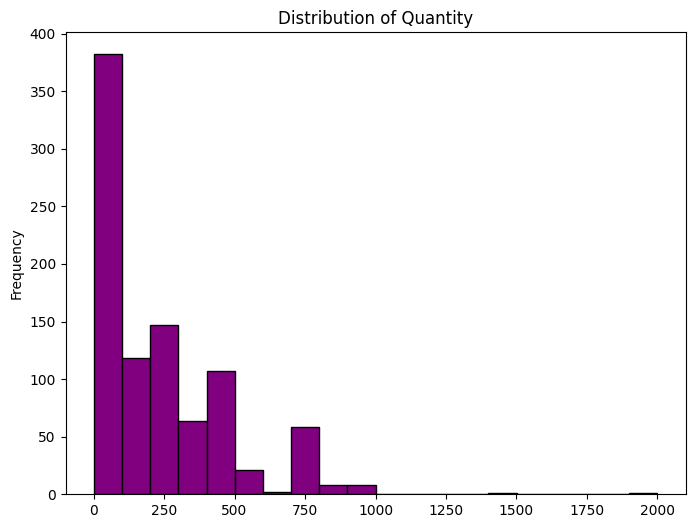

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file into a DataFrame
df = pd.read_csv(r'C:\Users\abhisriv\Documents\webscap\JoiMart\2023November23_05_10PM_\Jio_beverages_clean.csv')

# Plot the distribution of product quantities
plt.figure(figsize=(8, 6))
df['Quantity'].plot(kind='hist', bins=20, color='purple', edgecolor='black')
plt.title('Distribution of Quantity')
plt.show()

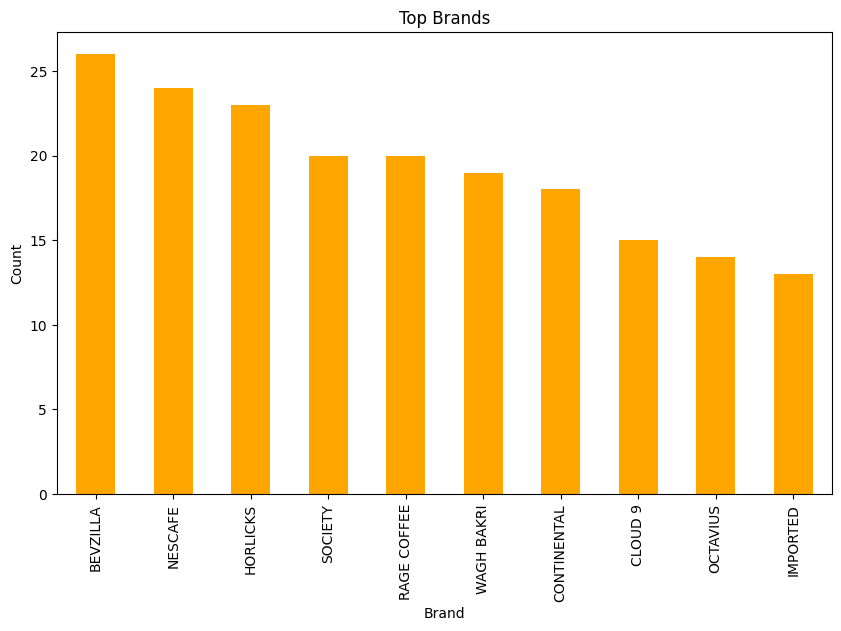

In [14]:
# Count the occurrences of each brand
brand_counts = df['Brand'].value_counts()

# Plot the top N brands
top_n = 10
plt.figure(figsize=(10, 6))
brand_counts.head(top_n).plot(kind='bar', color='orange')
plt.title('Top Brands')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.show()

In [15]:
# Calculate summary statistics
summary_stats = df.describe()
print(summary_stats)


       Unnamed: 0           MRP  Selling Price  PerUnitPrice     Quantity  \
count  987.000000    987.000000     987.000000           0.0   917.000000   
mean   493.000000    490.240496     371.124620           NaN   245.893337   
std    285.066659    880.102583     607.403502           NaN   248.336759   
min      0.000000      5.000000       5.000000           NaN     1.000000   
25%    246.500000    199.000000     154.000000           NaN    25.000000   
50%    493.000000    360.000000     277.000000           NaN   200.000000   
75%    739.500000    599.000000     449.500000           NaN   400.000000   
max    986.000000  20250.000000   12810.000000           NaN  2000.000000   

          Pack of     Discount  Discount Percentage  Price Per Unit(Kg/L)  
count  987.000000   987.000000           987.000000            912.000000  
mean     2.695035   119.115876            20.502644           3148.458388  
std      7.844534   325.474350            18.122771          15254.783786  
mi